# 0. Carregando bibliotecas

In [ ]:
# Geospatial data processing
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import networkx as nx
from shapely import Point


# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D


# Network analysis
#import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')
#plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {city2graph.__version__ if hasattr(city2graph, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.6


# 1. Baixar dados Overture Maps

O c√≥digo abaixo, faz o download dos dados, por tipo, mais recentes a partir de BBOX (longMax,latMax,longMin,atMin) ou de um Pol√≠gono.

In [57]:
# Carregar arquivos de refer√™ncia da pesquisa
bbox_ae = [-42.865397,-5.231538,-42.662587,-4.955767] # Teresina city centre bounding box
area_estudo = gpd.read_file("dados/zona_urbana/area_estudo_zu.geojson").to_crs(epsg=31983)
bbox_ae_3km = [-42.863200,-5.259269, -42.626205, -4.929381]
area_estudo_buffer3km = gpd.read_file("dados/zona_urbana/area_estudo_zu_buffer3km_1.geojson").to_crs(epsg=31983)

area_estudo["area_m2"] = area_estudo.area
area_estudo.insert(loc=len(area_estudo.columns) - 1, column="area_km2", value=area_estudo.area / 1000000)

area_estudo_buffer3km["area_m2"] = area_estudo_buffer3km.area
area_estudo_buffer3km["area_km2"] = area_estudo_buffer3km.area/1000000

print(f"√ÅREA DE ESTUDO (Km¬≤) = {area_estudo["area_km2"]}")
print(f"√ÅREA DE ESTUDO BUFFER 3KM (Km¬≤) = {area_estudo_buffer3km["area_km2"]}")

√ÅREA DE ESTUDO (Km¬≤) = 0    279.000697
Name: area_km2, dtype: float64
√ÅREA DE ESTUDO BUFFER 3KM (Km¬≤) = 0    537.453272
Name: area_km2, dtype: float64


#### Caso j√° tenha feito o download dos dados, pule a c√©lula abaixo

In [58]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Teresina city centre

city2graph.load_overture_data(
    area=bbox_ae_3km,
    types=["segment", "building", "connector"],
    output_dir="dados/overturemaps/intermediarios/",
    prefix="teresina_AE3km_script_",
    save_to_file=True,
    return_data=False
)

print("Dados baixados foi conclu√≠do.")

Dados baixados foi conclu√≠do.


#### Caso tenha pulado a c√©lula acima, fa√ßa o carregamento dos dados armazenados localmente.

In [59]:
# Load the downloaded GeoJSON files
# Convert to UTM 23 Sul Grade (EPSG:31983) for accurate distance calculations
buildings_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_building.geojson").to_crs(epsg=31983)
segments_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_segment.geojson").to_crs(epsg=31983)
connectors_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_connector.geojson").to_crs(epsg=31983)
ubs_gdf_ae = gpd.read_file("./dados/semplam/ubs_zu.geojson").to_crs(epsg=31983)

print("‚úÖ Dados Carregados com Sucesso!")
print("üìä Resumo do Conjunto de Dados:")

print(f"   ‚Ä¢ UBS: {len(ubs_gdf_ae):,}")
print(f"   ‚Ä¢ Buildings: {len(buildings_gdf_bboxae3km):,}")
print(f"   ‚Ä¢ Road segments: {len(segments_gdf_bboxae3km):,}")
print(f"   ‚Ä¢ Connectors: {len(connectors_gdf_bboxae3km):,}")
print("\n")
print("----------- SRC ORIGNAL -----------------")

print(f"   ‚Ä¢ √Årea de Estudo (ZU) -> CRS ORIGINAL: {area_estudo.crs}")
print(f"   ‚Ä¢ √Årea de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: {area_estudo_buffer3km.crs}")
print(f"   ‚Ä¢ UBS -> CRS ORIGINAL: {ubs_gdf_ae.crs}")
print(f"   ‚Ä¢ BUILDING -> CRS ORIGINAL: {buildings_gdf_bboxae3km.crs}")
print(f"   ‚Ä¢ SEGMENTS -> CRS ORIGINAL: {segments_gdf_bboxae3km.crs}")
print(f"   ‚Ä¢ CONNECTORS -> CRS ORIGINAL: {connectors_gdf_bboxae3km.crs}")

‚úÖ Dados Carregados com Sucesso!
üìä Resumo do Conjunto de Dados:
   ‚Ä¢ UBS: 75
   ‚Ä¢ Buildings: 445,720
   ‚Ä¢ Road segments: 55,387
   ‚Ä¢ Connectors: 40,204


----------- SRC ORIGNAL -----------------
   ‚Ä¢ √Årea de Estudo (ZU) -> CRS ORIGINAL: EPSG:31983
   ‚Ä¢ √Årea de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: EPSG:31983
   ‚Ä¢ UBS -> CRS ORIGINAL: EPSG:31983
   ‚Ä¢ BUILDING -> CRS ORIGINAL: EPSG:31983
   ‚Ä¢ SEGMENTS -> CRS ORIGINAL: EPSG:31983
   ‚Ä¢ CONNECTORS -> CRS ORIGINAL: EPSG:31983


#### Plotando dados iniciais

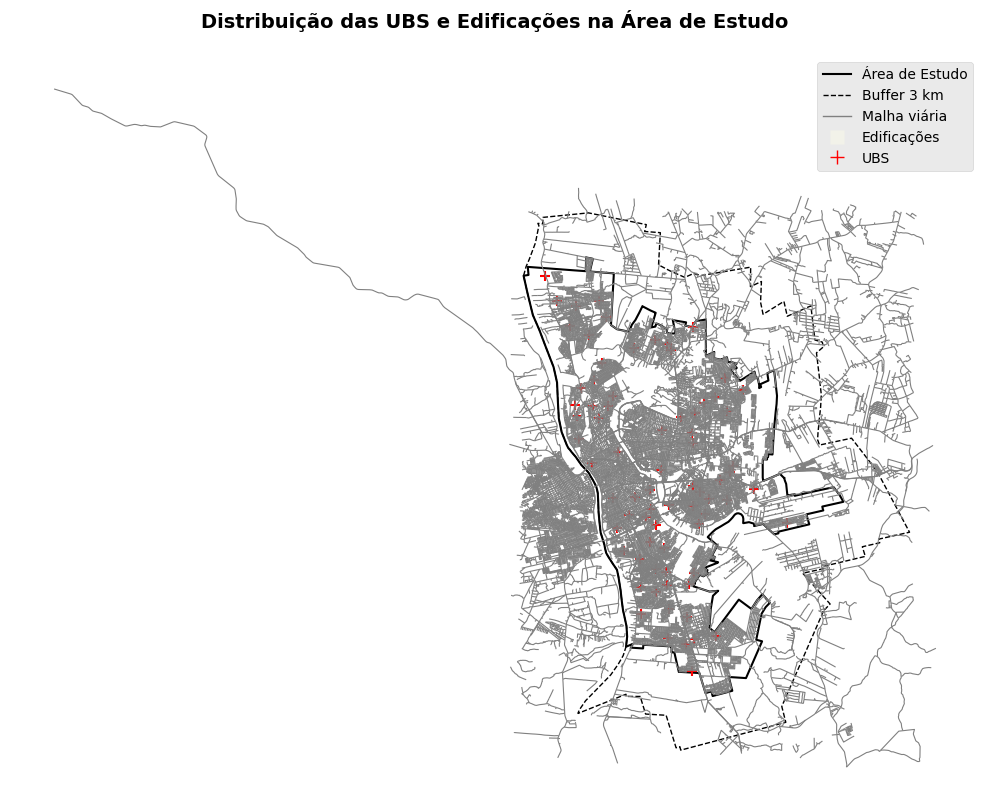

In [61]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 1Ô∏è‚É£ Buildings ‚Äî bege claro, sem contorno
#buildings_gdf_bboxae3km.plot(ax=ax, facecolor='#f2f2e9', edgecolor='none', label='Edifica√ß√µes')

# 2Ô∏è‚É£ Malha vi√°ria ‚Äî linhas cinza
segments_gdf_bboxae3km.plot(ax=ax, color='gray', linewidth=0.8, label='Malha vi√°ria')

# 3Ô∏è‚É£ √Årea de Estudo Buffer 3 km ‚Äî contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 4Ô∏è‚É£ √Årea de Estudo ‚Äî contorno preto cont√≠nuo
area_estudo.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='√Årea de Estudo')

# 5Ô∏è‚É£ UBS ‚Äî cruz vermelha
ubs_gdf_ae.plot(ax=ax, color='red', marker='+', markersize=50, label='UBS')

# --- Personaliza√ß√£o do t√≠tulo e layout ---
ax.set_title("Distribui√ß√£o das UBS e Edifica√ß√µes na √Årea de Estudo", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='√Årea de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Buffer 3 km'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha vi√°ria'),
    Line2D([0], [0], marker='s', color='#f2f2e9', markeredgecolor='none',
           markersize=10, label='Edifica√ß√µes', linestyle=''),
    Line2D([0], [0], marker='+', color='red', markersize=10, label='UBS', linestyle='')
]

ax.legend(handles=custom_legend, loc='upper right', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# 2. Opera√ß√£o Espacial (Intersec√ß√£o)
Como parte da organiza√ß√£o da base de dados, irei realizar a opera√ß√£o espacial INTERSE√áAO para obter apenas as "pegadas de constru√ß√µes", segmentos e conectores dentro da zona urbana 3km

## BUILDING

<Axes: >

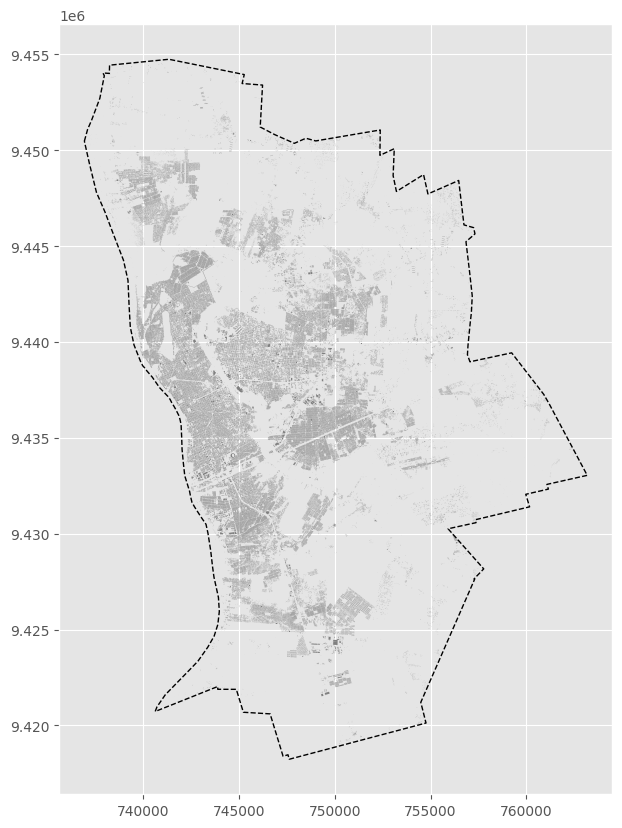

In [62]:
# Vamos realizar um opera√ß√£o espacial de interse√ß√£o para obter apenas as vias dentro da zona urbana 3km
buildings_gdf_ae3km = buildings_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

# 1Ô∏è‚É£ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2Ô∏è‚É£ Malha vi√°ria ‚Äî linhas cinza
buildings_gdf_ae3km.plot(ax=ax, color='gray', linewidth=0.2, label='Malha vi√°ria')

# 3Ô∏è‚É£ √Årea de Estudo Buffer 3 km ‚Äî contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [63]:
buildings_gdf_ae3km.to_file(
    "dados/overturemaps/buildings_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
)

## SEGMENTOS

In [64]:
# Vamos realizar um opera√ß√£o espacial de interse√ß√£o para obter apenas as vias dentro da zona urbana 3km
segments_gdf_ae3km = segments_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

In [67]:
# >>> IN√çCIO DO NOVO C√ìDIGO DE FILTRAGEM <<<
print(f"N√∫mero de segmentos de via antes da 1¬™ filtragem: {len(segments_gdf_ae3km)}")

# 1. PRIMEIRO FILTRO: Manter apenas subtype == 'road' (excluding pedestrian paths, railways, etc.)
segments_gdf_ae3km_road = segments_gdf_ae3km[segments_gdf_ae3km['subtype'] == 'road']
print(f"N√∫mero de segmentos ap√≥s filtrar por subtype='road': {len(segments_gdf_ae3km_road)} ({len(segments_gdf_ae3km)-len(segments_gdf_ae3km_road)})")


# 2. SEGUNDO FILTRO: Sobre o resultado anterior, filtrar pela classe da via
vias_para_manter = [
    'primary', 
    'secondary', 
    'tertiary', 
    'trunk', 
    'residential', 
    'unclassified'
]
# Filtra o GeoDataFrame do passo 1, mantendo apenas as classes desejadas
segments_gdf_ae3km_road_class = segments_gdf_ae3km_road[segments_gdf_ae3km_road['class'].isin(vias_para_manter)]

print(f"N√∫mero de segmentos ap√≥s filtrar por 'class' (resultado final): {len(segments_gdf_ae3km_road_class)} ({len(segments_gdf_ae3km_road)-len(segments_gdf_ae3km_road_class)})")

N√∫mero de segmentos de via antes da 1¬™ filtragem: 45224
N√∫mero de segmentos ap√≥s filtrar por subtype='road': 45191 (33)
N√∫mero de segmentos ap√≥s filtrar por 'class' (resultado final): 41246 (3945)


<Axes: >

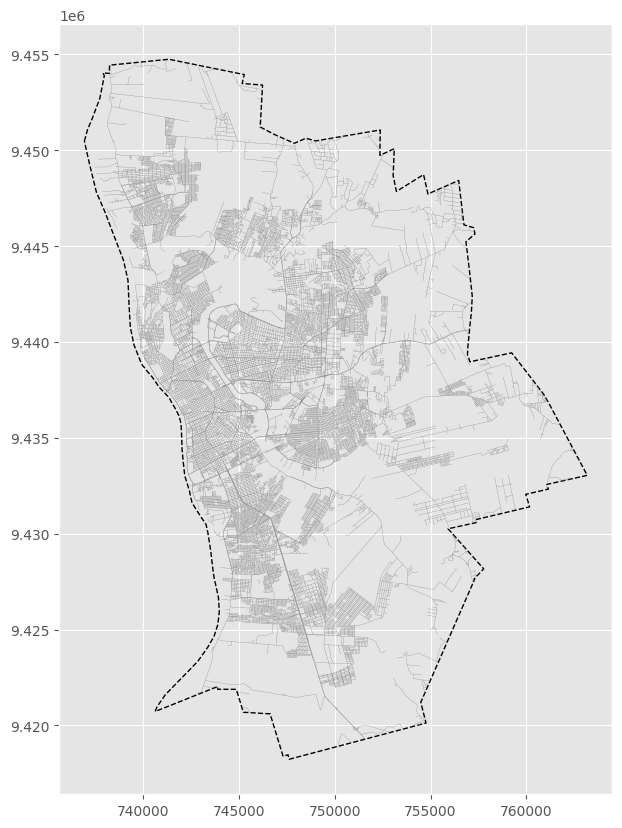

In [68]:
# 1Ô∏è‚É£ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2Ô∏è‚É£ Malha vi√°ria ‚Äî linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.2, label='Malha vi√°ria')

# 3Ô∏è‚É£ √Årea de Estudo Buffer 3 km ‚Äî contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [70]:
segments_gdf_ae3km_road_class.to_file(
    "dados/overturemaps/segment_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
)

## Conectores (N√≥s)

In [71]:
# Vamos realizar um opera√ß√£o espacial de interse√ß√£o para obter apenas os conectores (n√≥s) dentro da zona urbana 3km
connectors_gdf_ae3km = connectors_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

<Axes: >

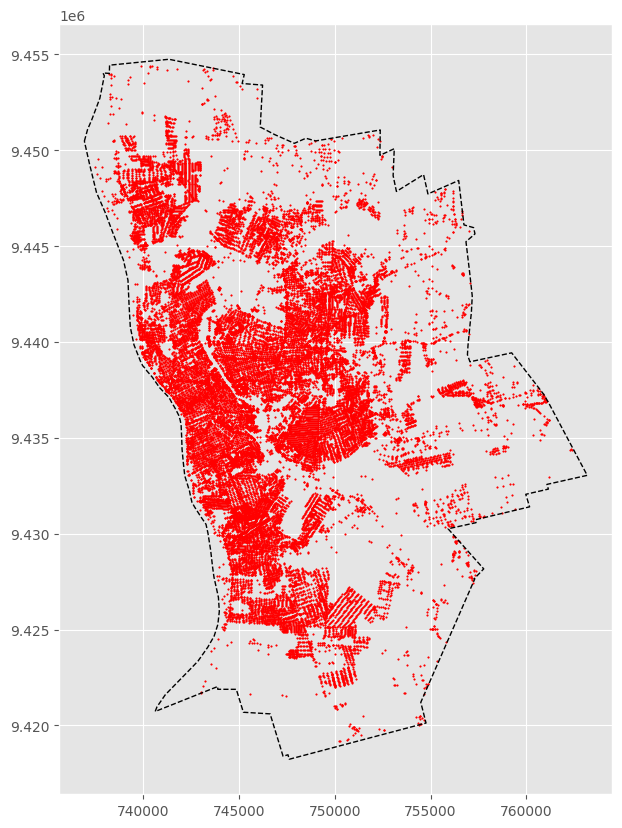

In [72]:
# 1Ô∏è‚É£ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2Ô∏è‚É£ Malha vi√°ria ‚Äî linhas cinza
connectors_gdf_ae3km.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

# 3Ô∏è‚É£ √Årea de Estudo Buffer 3 km ‚Äî contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

## Sobrepondo os N√≥s ao Segmento

<Axes: >

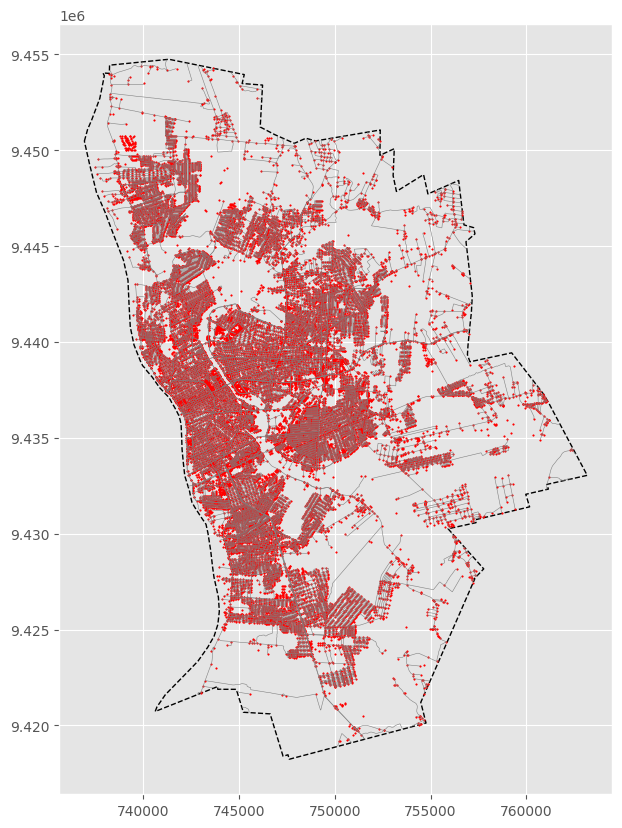

In [73]:
# 1Ô∏è‚É£ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2Ô∏è‚É£ Malha vi√°ria ‚Äî linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.4, label='Malha vi√°ria')

# 3Ô∏è‚É£ √Årea de Estudo Buffer 3 km ‚Äî contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5Ô∏è‚É£ Conectores de Trechos de rua ‚Äî c√≠rculo vermelho
connectors_gdf_ae3km.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

Ap√≥s a exclus√£o de alguns segmentos, alguns n√≥ ficaram desconectados da rede. Necess√°rio exclu√≠-los.

In [84]:
# Vamos realizar um opera√ß√£o espacial de interse√ß√£o para obter apenas os conectores (n√≥s) que tocam a rede
print(f"N√∫mero total de n√≥ antes da opera√ß√£o {len(connectors_gdf_ae3km)}")
connectors_gdf_ae3km_valid = connectors_gdf_ae3km.overlay(segments_gdf_ae3km_road_class, how='intersection')
# Encontrando pontos duplicados e removendo-os, deixando apenas o √∫ltimo valor
connectors_gdf_ae3km_valid_drop = connectors_gdf_ae3km_valid.drop_duplicates(['id_1'], keep='first')
print(f"N√∫mero total de n√≥ depois da opera√ß√£o {len(connectors_gdf_ae3km_valid_drop)} ({len(connectors_gdf_ae3km) - len(connectors_gdf_ae3km_valid_drop)})")

N√∫mero total de n√≥ antes da opera√ß√£o 33019
N√∫mero total de n√≥ depois da opera√ß√£o 28777 (4242)


<Axes: >

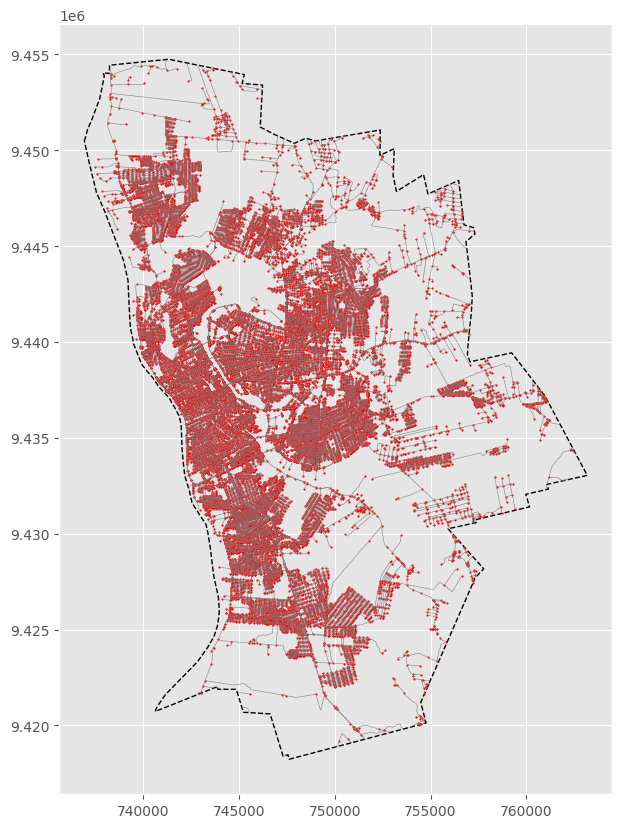

In [86]:
# 1Ô∏è‚É£ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2Ô∏è‚É£ Malha vi√°ria ‚Äî linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.4, label='Malha vi√°ria')

# 3Ô∏è‚É£ √Årea de Estudo Buffer 3 km ‚Äî contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5Ô∏è‚É£ Conectores de Trechos de rua ‚Äî c√≠rculo vermelho
connectors_gdf_ae3km_valid_drop.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

In [87]:
connectors_gdf_ae3km_valid_drop.to_file(
    "dados/overturemaps/connectors_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8'
)

# 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [6]:
buildings_gdf = gpd.read_file("./dados/overturemaps/buildings_ae3km.geojson", columns=['id', 'subtype', 'class', 'geometry'])

segments_gdf = gpd.read_file("./dados/overturemaps/segment_ae3km.geojson", columns=['id', 'subtype', 'class', 'names', 'connectors',
       'routes', 'subclass_rules', 'access_restrictions', 'level_rules',
       'destinations', 'prohibited_transitions', 'road_surface',
       'road_flags', 'speed_limits', 'width_rules', 'subclass', 'geometry'])

connectors_gdf = gpd.read_file("./dados/overturemaps/connectors_ae3km.geojson", columns=["id_1","geometry"])

In [8]:
import pandas as pd
import json

# --- 1. Mapeamentos baseados no C√≥digo de Tr√¢nsito Brasileiro (CTB) ---

# Dicion√°rio com as velocidades M√ÅXIMAS legais (em km/h)
speed_max_map_ctb = {
    'trunk': 80.0,        # Via de Tr√¢nsito R√°pido
    'primary': 60.0,      # Via Arterial
    'secondary': 40.0,    # Via Coletora
    'tertiary': 40.0,     # Via Coletora
    'residential': 30.0,  # Via Local
    'unclassified': 30.0  # Via Local
}

# Dicion√°rio com as velocidades M√çNIMAS legais (metade da m√°xima)
speed_min_map_ctb = {key: value / 2 for key, value in speed_max_map_ctb.items()}

# Dicion√°rio com as velocidades M√âDIAS REALISTAS para modelagem
speed_avg_map_model = {
    'trunk': 50.0,
    'primary': 40.0,
    'secondary': 30.0,
    'tertiary': 25.0,
    'residential': 20.0,
    'unclassified': 20.0
}


# --- 2. Fun√ß√£o para preencher os valores nulos em 'speed_limits' com dados do CTB ---
def preencher_limites_ctb(row):
    """
    Preenche 'speed_limits' nulos com os valores M√ÅXIMOS e M√çNIMOS do CTB.
    """
    if pd.isna(row['speed_limits']):
        road_class = row['class']
        
        # Pega os valores max e min dos nossos mapas CTB
        max_speed = speed_max_map_ctb.get(road_class, 30.0) # Default de 30 para seguran√ßa
        min_speed = speed_min_map_ctb.get(road_class, 15.0) # Default de 15
        
        data_structure = [{
            "min_speed": { "value": min_speed, "unit": "km\\/h" }, # Preenchendo min_speed
            "max_speed": { "value": max_speed, "unit": "km\\/h" },
            "is_max_speed_variable": None,
            "when": None,
            "between": None
        }]
        return json.dumps(data_structure)
    else:
        return row['speed_limits']

# --- 3. Aplicar a fun√ß√£o para atualizar a coluna 'speed_limits' ---
print("Preenchendo 'speed_limits' com valores M√ÅX/M√çN do CTB...")
segments_gdf['speed_limits'] = segments_gdf.apply(preencher_limites_ctb, axis=1)
print("Coluna 'speed_limits' atualizada.")


# --- 4. Criar a nova coluna com a VELOCIDADE M√âDIA para modelagem ---
print("\nCriando coluna de velocidade m√©dia para modelagem...")
# A fun√ß√£o .map() √© uma forma muito eficiente de fazer isso
segments_gdf['velocidade_media_kmh'] = segments_gdf['class'].map(speed_avg_map_model)
# Preencher qualquer valor que n√£o foi mapeado (caso haja uma 'class' inesperada)
segments_gdf['velocidade_media_kmh'].fillna(20.0, inplace=True)
print("Coluna 'velocidade_media_kmh' criada.")

Preenchendo 'speed_limits' com valores M√ÅX/M√çN do CTB...
Coluna 'speed_limits' atualizada.

Criando coluna de velocidade m√©dia para modelagem...
Coluna 'velocidade_media_kmh' criada.


<positron-console-cell-8>:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [ ]:
# --- 5. Calcular o TEMPO DE VIAGEM a partir da velocidade M√âDIA ---
print("\nCalculando o tempo de viagem a partir da velocidade m√©dia...")
# Converter a velocidade m√©dia para m/min
velocidade_mmin = segments_gdf['velocidade_media_kmh'] * 1000 / 60
# Calcular o tempo de viagem em min
segments_gdf['tempo_viagem_min'] = segments_gdf.geometry.length / velocidade_mmin
print("Coluna 'tempo_viagem_min' criada e pronta para a an√°lise de is√≥cronas.")


# --- 6. Verifica√ß√£o Final ---
print("\nVerifica√ß√£o Final:")
# Contar nulos na coluna principal (esperado: 0)
print(f"Nulos em 'speed_limits': {segments_gdf_zu['speed_limits'].isna().sum()}")
# Contar nulos na coluna de velocidade m√©dia (esperado: 0)
print(f"Nulos em 'velocidade_media_kmh': {segments_gdf_zu['velocidade_media_kmh'].isna().sum()}")

print("\nAmostra do resultado final com as novas colunas:")
display(segments_gdf_zu[['class', 'speed_limits', 'velocidade_media_kmh', 'tempo_viagem_min']].sample(5))

# 2.1 Processamento dos N√≥ sem grafo

Ap√≥s a filtrangem dos segmentos do tipo road e das class, algum n√≥s ficaram sem aresta e devem ser  exclu√≠dos do conjunto

In [ ]:
import geopandas as gpd

# --- Pr√©-requisito: Garantir que ambos os GeoDataFrames tenham o mesmo CRS ---
# Se eles n√£o tiverem o mesmo CRS, a opera√ß√£o falhar√°.
if connectors_gdf.crs != segments_gdf.crs:
    print("Aviso: Os CRS s√£o diferentes. Projetando os n√≥s para o CRS dos segmentos...")
    connectors_gdf = connectors_gdf.to_crs(segments_gdf.crs)

# --- A Solu√ß√£o ---
print(f"N√∫mero de n√≥s ANTES da limpeza: {len(connectors_gdf)}")

# Realiza a jun√ß√£o espacial. Mant√©m apenas os n√≥s que intersectam a rede de segmentos.
# how='inner': S√≥ mant√©m os n√≥s que encontram uma rua correspondente.
# predicate='intersects': A regra para a correspond√™ncia espacial.
connectors_gdf_zu_ok = gpd.sjoin(connectors_gdf, segments_gdf, how="inner", predicate="intersects")

# --- Limpeza Final ---
# A jun√ß√£o espacial adiciona colunas do GeoDataFrame de segmentos.
# Vamos remover duplicatas caso um n√≥ toque mais de uma rua e manter apenas as colunas originais dos n√≥s.
# Primeiro, obtemos o nome das colunas originais dos n√≥s.
colunas_originais_nos = connectors_gdf.columns

# Remove duplicatas de n√≥s (baseado no √≠ndice original) e seleciona as colunas originais
connectors_gdf_zu_ok = connectors_gdf_zu_ok.drop_duplicates(subset='index_right').loc[:, colunas_originais_nos]


print(f"N√∫mero de n√≥s AP√ìS a limpeza: {len(connectors_gdf_zu_ok)}")

# Agora, 'nos_conectados_gdf' cont√©m apenas os pontos que est√£o conectados √† sua rede filtrada.

## Check-Point dos dados: Salvar em arquivos f√≠sicos:

- segments_gdf_zu
- buildings_gdf_zu

In [ ]:
# Extra controle
# ===================================================================
# ===================================================================

# Exportar o GeoDataFrame para o formato GeoJSON
# √â uma boa pr√°tica especificar a codifica√ß√£o para evitar problemas com caracteres especiais (acentos)
segments_gdf_zu.to_file(
    "dados/overturemaps/segments_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

buildings_gdf_zu.to_file(
    "dados/overturemaps/intermediarios/buildings_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print("Arquivo GeoJSON salvo com sucesso")

In [ ]:
# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf_zu_barreiras = city2graph.process_overture_segments(
    segments_gdf=buildings_gdf_zu,
    get_barriers=True,
    connectors_gdf=connectors_gdf_zu,
    threshold=1.0
)

print(f"‚úÖ Processed {len(segments_gdf_zu_barreiras)} road segments")
print("üìà Barrier geometries created for tessellation")

barriers = segments_gdf_zu_barreiras["barrier_geometry"]

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf_zu_barreiras["barrier_geometry"].geom_type.value_counts()
print("\nüîç Barrier geometry types:")
for geom_type, count in geometry_types.items():
    print(f"   ‚Ä¢ {geom_type}: {count:,}")

In [ ]:
barriers.plot()

In [ ]:
segments_gdf.head()

In [ ]:
# Extra controle
# ===================================================================
# ===================================================================

# Definir o nome do arquivo de sa√≠da
output_filename = 'dados/overturemaps/resultado/segments_road_filtrado.geojson'

# Exportar o GeoDataFrame para o formato GeoJSON
# √â uma boa pr√°tica especificar a codifica√ß√£o para evitar problemas com caracteres especiais (acentos)
segments_gdf_filtrado1.to_file(
    output_filename, 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print(f"Arquivo GeoJSON salvo com sucesso em: {output_filename}")

# 4. Creating Morphological Graphs

Now we‚Äôll create the morphological graph - the core contribution of city2graph. This process:

![image.png](https://city2graph.net/_images/morph_net_process.png)

## The Process:

1. **Tessellation Creation**: Divide space into private areas using street segments as barriers
2. **Network Extraction**: Identify three types of spatial relationships:
    - Private-to-private (red): Adjacency between neighboring private spaces
    - Public-to-public (blue): Connectivity along street networks
    - Private-to-public (purple): Interface between private spaces and streets

## Why Morphological Graphs?

Unlike traditional approaches that analyze street networks and buildings separately, morphological graphs provide a **unified representation** of urban space that:

- Captures the complete topology of public and private spaces
- Enables holistic urban analysis combining street accessibility and land use
- Provides a foundation for spatially-explicit graph machine learning
- Supports integration of diverse urban attributes (POIs, demographics, functions)

In [ ]:
# Define center point for the analysis area (Centro da cidade de Teresina)
center_point = gpd.GeoSeries([Point(-5.08305465, -42.77597849)], crs='EPSG:4326').to_crs(epsg=31983)

# Garante que os √≠ndices sejam num√©ricos, simples e sequenciais
#buildings_gdf = buildings_gdf.reset_index(drop=True)
#segments_gdf = segments_gdf.reset_index(drop=True)

# Create the morphological graph
print("üèóÔ∏è  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("‚úÖ Morphological graph created successfully!")
print("üìä Network summary:")
print(f"   ‚Ä¢ Node types: {list(morpho_nodes.keys())}")
print(f"   ‚Ä¢ Edge types: {list(morpho_edges.keys())}")
print(f"   ‚Ä¢ Private spaces: {len(morpho_nodes['private']):,}")
print(f"   ‚Ä¢ Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   ‚Ä¢ {edge_type}: {len(edge_gdf):,} connections")

In [ ]:
morpho_nodes["private"].head()


In [ ]:
morpho_nodes["public"].head()


In [ ]:
morpho_edges[('public', 'connected_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'faced_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'touched_to', 'private')].head()


In [ ]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right',
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()